<div>
    <h2><center>Global Glacier Velocity Data Downloading</center></h2>
</div>

# Setting up a local environment
at the terminal:
>conda create --name Glaciervel -c conda-forge h5netcdf fiona shapely jupyter netcdf4 psutil h5py zarr matplotlib gdal xarray  boto3 pyproj ipympl ipyleaflet s3fs geopandas rasterio seaborn markdown

activate newly created environment:
> conda activate Glaciervel

start jupyter in browser
> jupyter notebook



In [5]:
# Fetch the path for essential python scripts

import os
import sys
path =  os.getcwd()

# Import python scripts from scripts folder
sys.path.append(path + '/scripts')
%matplotlib widget

In [2]:
# Import all the necessary packages


import matplotlib
import matplotlib.pyplot as plt
import markdown
from velocity_widget import ITSLIVE
matplotlib.rcParams['figure.figsize'] = [9, 5]
matplotlib.rcParams["figure.autolayout"] = True
velocity_widget = ITSLIVE()
plt.close()
import xarray as xr
import numpy as np
import time
from pyproj import Transformer
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd
from ipywidgets import widgets, HTML, Output
import numpy as np
import math
import glob


## Instructions: 

**First Step**
- Select type_dataset: "Yearly" or "Daily" ("Daily" does not necessarily cover every day, just has a higher time resolution). Yearly datasets can be much bigger spatially than the daily ones (because they have only 1 time dimension, while daily dataset might have thousands).
- Select a starting date and ending date (format 'yyyy-mm-dd').
- If you chose "Daily", consider changing the "threshold" value. 

#### How to use the interactive map

Run the next two cells, and wait for the map to appear.

If you chose "Yearly" dataset:
- Select an Area Of Interest (AOI) by placing two markers on the map with a right click. Once you have two markers, a blue rectangle representing your AOI will be plotted. If you made a mistake, plot a rectangle then click on "Clear points".

If you chose "Daily" dataset:
- Same as for the "Yearly" dataset: draw a rectangle with two markers (right click).
- Once the rectangle has been drawn, "sprinkle" the area with a few points by left double-clicking. A cross will appear for each point. That is because your Area Of Interest (AOI) might be divided into several datacubes. 
- Click on the "Get points".
- Once prompted, follow the next step.

**To download the data**
Click on "Export data". Once the message saying it has finished downloading has appeared, you can plot it to see what you downloaded. *Be aware, downloading will take some time*.

**To plot the data**
Click on the blue 'plot' button when prompted (after exporting the data).




**MAKE SURE THAT:**
- You keep the "Daily" datacubes reasonnably small: downloading them takes a lot of memory. I encourage to slice them by date selection. You can also change the threshold set to 40% (meaning it will keep only the time slices with 40% or more data, discard the rest)
- All the points you want are in the Area Of Interest (AOI) for which you chose the boundaries' coordinates.
- Don't worry if it takes time to download the data, these are big dataset.

##### As of the 26/10/22, "Yearly" dataset are available from 1985 until 2018 included. If your date range is bigger than that, the code will still run and give an error because the dataset are not available. "Daily" dataset are available between 2013 to now.

In [3]:

# Select the type of dataset you want to download: 'Yearly' or 'Daily'
type_dataset = "Yearly"

# Select your date range (careful the datacubes get heavy quickly)
sdate = '2015-01-01'
edate = '2018-01-01'

# Select Threshold quality
threshold = 40


#### Run the following Cell

GridBox(children=(VBox(children=(Map(bottom=38149.0, center=[60.15654283139454, -139.14459228515628], controls…

all points cleared
[]
Downloading...
downloaded 2015 spatial slice    131.2 seconds
downloaded 2016 spatial slice    130.9 seconds
downloaded 2017 spatial slice    132.2 seconds
downloaded 2018 spatial slice    133.3 seconds
Done ! You can hit "plot" now


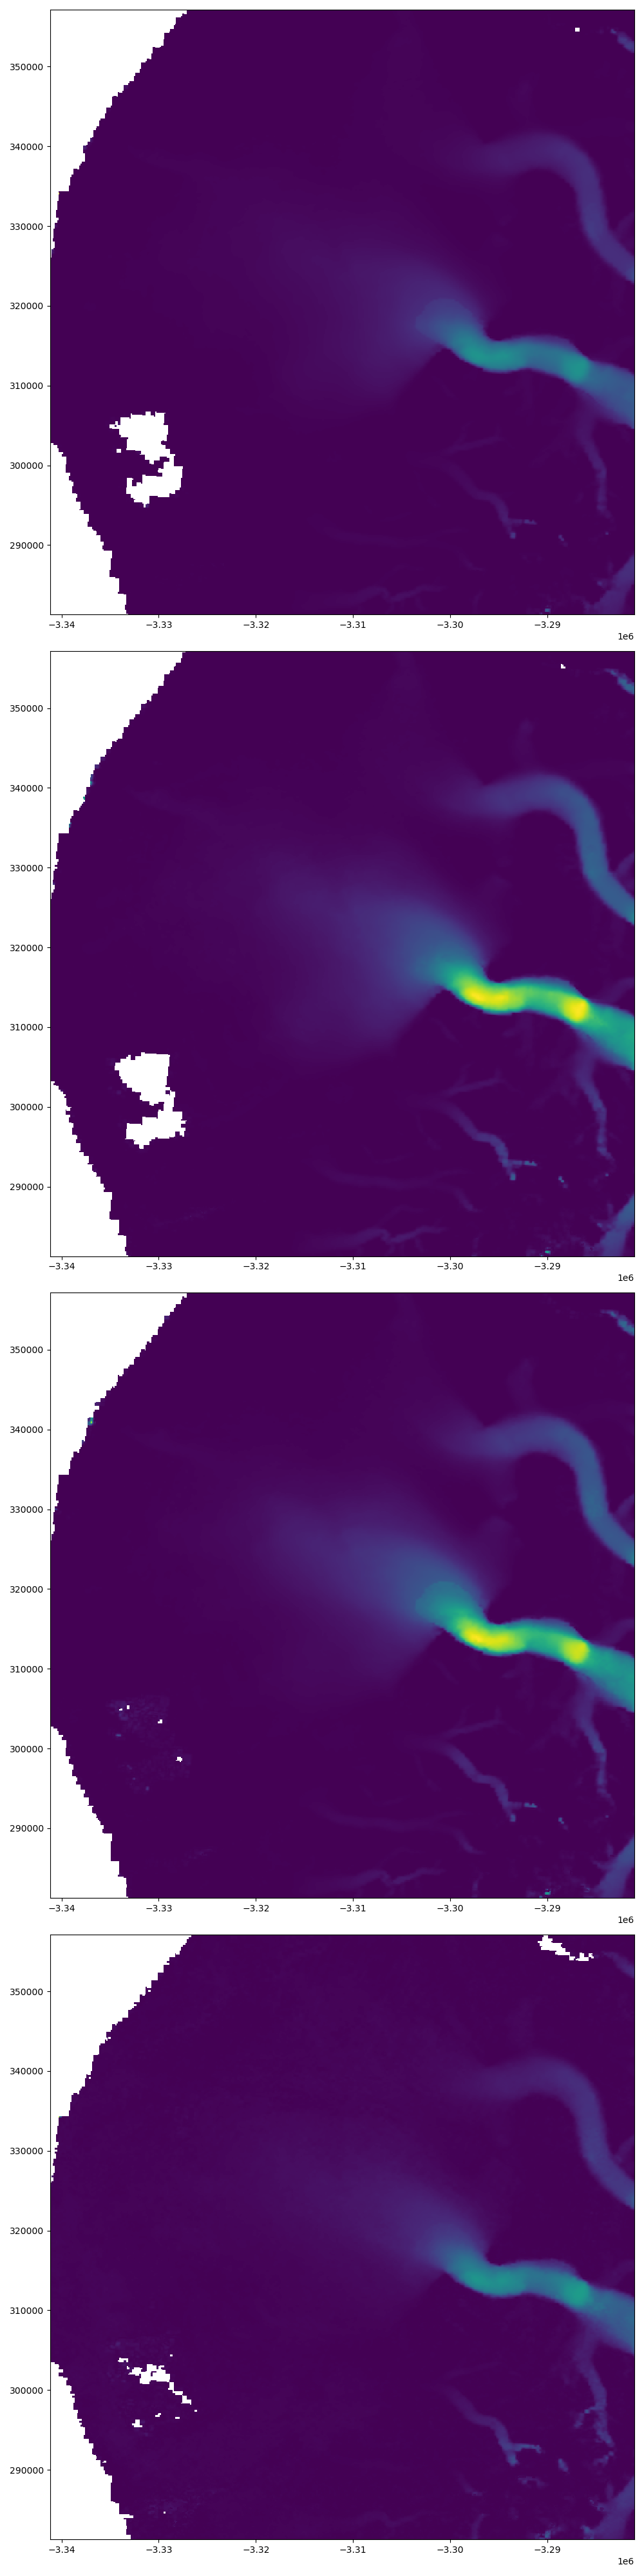

In [6]:
   
dates_range = widgets.SelectionRangeSlider(
    options=[i for i in range(546)],
    index=(1, 120),
    continuous_update=False,
    description='Interval (days): ',
    orientation='horizontal',
    layout={'width': '90%',
            'display': 'flex'},
    style={'description_width': 'initial'})

variables =  widgets.Dropdown(
    options=['v', 'v_error', 'vx', 'vy'],
    description='Variable: ',
    disabled=False,
    value='v',
    layout={'width': '20%',
            'display': 'flex'},
    style={'description_width': 'initial'})

plot_type =  widgets.Dropdown(
    options=['location', 'satellite'],
    description='Plot By: ',
    disabled=False,
    value='location',
    layout={'width': '20%',
            'display': 'flex'},
    style={'description_width': 'initial'})

plot_button =  widgets.Button(
    description='Plot',
    button_style='primary',
    icon='line-chart',
    style={'description_width': 'initial'})

get_points =  widgets.Button(
    description='Get points',
    button_style='primary',
    icon='line-chart',
    style={'description_width': 'initial'})

clear_button =  widgets.Button(
    description='Clear Points',
    # button_style='warning',
    icon="trash",
    style={'description_width': 'initial'})

latitude = widgets.BoundedFloatText(
    value=0.0,
    min=-90.0,
    max=90.0,
    step=0.1,
    description='Lat: ',
    disabled=False,
    style={'description_width': 'initial'},
    layout={'width': '20%',
            'display': 'flex'},
)

longitude = widgets.BoundedFloatText(
    value=0.0,
    min=-180.0,
    max=180.0,
    step=0.1,
    description='Lon: ',
    disabled=False,
    style={'description_width': 'initial'},
    layout={'width': '20%',
            'display': 'flex'},
)

add_button =  widgets.Button(
    description='Add Point',
    # button_style='info',
    icon="map-marker",
    style={'description_width': 'initial'})

include_running_mean =  widgets.Checkbox(
            value=False,
            description="Include Running Mean",
            style={'description_width': 'initial'},
            disabled=False,
            indent=False,
            tooltip="Plot running mean through each time series",
            layout=widgets.Layout(width="25%"),
        )

export_button = widgets.Button(
    description='Export Data',
    # button_style='info',
    icon="file-export",
    style={'description_width': 'initial'})

data_link = widgets.HTML(
    value="<br>"
)

# If this congiguration changes we need to rerun the cell.
config = { 
    "plot": "v", # or other ITS_LIVE variables: vx, vy ...
    "min_separation_days": 1,
    "max_separation_days": 90,
    "color_by": "location", # valid values: satellite, points
    "verbose": True, # print operations
    "runnig_mean": True,
    "coords": {
        "latitude": latitude,
        "longitude": longitude
    },
    "data_link": data_link
}


def downloader(whatever):
    print('Downloading...')
    global pathsave
    ######### YEARLY DATASET DOWNLOAD ########
    if type_dataset == 'Yearly':

            # Create list of years for the date range chosen earlier
            list_years = np.arange(int(sdate.split('-')[0]), int(edate.split('-')[0])+1)

            # Create path to the files
            pathsave = velocity_widget.path_yearly_datacubes
            os.makedirs(pathsave, exist_ok = True)
            


            for Y in range(len(list_years)):

                    # Generate URL for the nc file
                    url = f'{velocity_widget.url_region[0]}{int(list_years[Y])}.nc#mode=bytes'

                    # Load datacube according to prerequisites (time, space and variables)
                    start = time.time()
                    xrds = xr.open_dataset(url
                                            ).sel(x=slice(velocity_widget.xmin_proj, velocity_widget.xmax_proj),
                                                y=slice(velocity_widget.ymax_proj, velocity_widget.ymin_proj)).load()

                    print(f"downloaded {list_years[Y]} spatial slice {time.time()-start:8.1f} seconds")
                    xrds.to_netcdf(f"{pathsave}{list_years[Y]}.nc")




    ######## DAILY DATASET DOWNLOAD ########
    else:

            # Create path to the files
            pathsave = velocity_widget.path_daily_datacubes
            os.makedirs(pathsave, exist_ok = True)

            # Get the cube address
            cubes = velocity_widget.dct.addresses
            cubes = [*set(cubes)]

            # List of variables to drop for the download (we drop everything but the variables written below)
            variables_drop = [ele for ele in list(
                    xr.open_dataset(cubes[0], engine='zarr').variables
                    ) if ele not in ['mid_date','x','y','acquisition_date_img1', 'acquisition_date_img2', 'date_center', 'date_dt', 'satellite_img1','satellite_img2', 'v','vx','vy','roi_valid_percentage']
            ]

            
            for n in range(len(cubes)):

                    # Get the cube's URL
                    url = cubes[n]

                    # Load indices of slices above the quality threshold
                    valid = xr.open_dataset(cubes[n], engine='zarr').roi_valid_percentage.values

                    # Grab the time values
                    t = xr.open_dataset(cubes[n], engine='zarr').mid_date.values

                    # Create a time mask, based on the validity of layers and the custom date-range
                    t_mask = np.logical_and(valid>threshold, np.logical_and(t>np.datetime64(sdate), t<np.datetime64(edate)))
                    
                    # Load datacube according to prerequisites (time, space and variables)
                    start = time.time()
                    xrds = xr.open_dataset(url,
                                            engine='zarr',
                                            drop_variables=variables_drop
                                            ).sel(mid_date=t_mask,
                                                x=slice(velocity_widget.xmin_proj, velocity_widget.xmax_proj),
                                                y=slice(velocity_widget.ymax_proj, velocity_widget.ymin_proj)).load()

                    print(f"downloaded {cubes[n].split('/')[-1].split('.')[0]} spatial slice {time.time()-start:8.1f} seconds")
                    xrds.to_netcdf(f"{pathsave}{cubes[n].split('/')[-1].split('.')[0]}_{sdate}_{edate}.nc")
    print('Done ! You can hit "plot" now')

def plotter(whatever):
    list_files = glob.glob(f'{pathsave}*.nc')

    fig, ax = plt.subplots(len(list_files), figsize=(10,10*len(list_files)))

    if len(list_files) == 1:
        if type_dataset == "Yearly":
            ax.pcolormesh(xr.open_dataset(list_files[0]).x.values,xr.open_dataset(list_files[0]).y.values,xr.open_dataset(list_files[0]).v.values)
        else:
            ax.pcolormesh(xr.open_dataset(list_files[0]).x.values,xr.open_dataset(list_files[0]).y.values,np.nanmean(xr.open_dataset(list_files[0]).v.values,axis = 0))
    else:
        if type_dataset == "Yearly":
            for i in range(len(list_files)):
                ax[i].pcolormesh(xr.open_dataset(list_files[i]).x.values,xr.open_dataset(list_files[i]).y.values,xr.open_dataset(list_files[i]).v.values)
        else:
            for i in range(len(list_files)):
                ax[i].pcolormesh(xr.open_dataset(list_files[i]).x.values,xr.open_dataset(list_files[i]).y.values,np.nanmean(xr.open_dataset(list_files[i]).v.values,axis = 0))


def update_variable(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["plot"] = variables.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_range(change):
        if change['type'] == 'change' and change['name'] == 'value':
            start, end = change['new']
            config["min_separation_days"] = start
            config["max_separation_days"] = end
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_plottype(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["color_by"] = plot_type.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_mean(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["running_mean"] = include_running_mean.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def add_point(event):
    coords = (latitude.value, longitude.value)
    velocity_widget.add_point(coords)
    
def export_ts(event):
    velocity_widget.export_data()

get_points.on_click(velocity_widget.plot_time_series)
plot_button.on_click(plotter)
clear_button.on_click(velocity_widget.clear_points)

export_button.on_click(downloader)


add_button.on_click(add_point)
dates_range.observe(update_range, 'value')
plot_type.observe(update_plottype, 'value')
variables.observe(update_variable, 'value')
include_running_mean.observe(update_mean, 'value')

layout = widgets.Layout(align_items='stretch',
                        display='flex',
                        flex_flow='row wrap',
                        border='none',
                        grid_template_columns="repeat(auto-fit, minmax(720px, 1fr))",
                        # grid_template_columns='48% 48%',
                        width='99%',
                        height='100%')

velocity_widget.set_config(config)

velocity_widget.fig.canvas.capture_scroll = True

# We render the widget
widgets.GridBox([
                widgets.VBox([velocity_widget.map,
                            widgets.HBox([latitude, longitude, add_button, clear_button], layout=widgets.Layout(align_items="flex-start",
                                                                                                                flex_flow='row wrap'))],
                            
                            layout=widgets.Layout(min_width="100%",
                                                    display="flex",
                                                    # height="100%",
                                                    # max_height="100%",
                                                    max_width="100%")),
                widgets.VBox([
                            widgets.HBox([get_points, export_button, plot_button, data_link])
                            ], layout=widgets.Layout(min_width="720px",
                                                        overflow='scroll',
                                                        max_width="100%",
                                                        display='flex'))],
                layout=layout)


